<h4>ChatGPT Internal Product Consistency Analysis</h4>
<p>
This notebook examines ChatGPT’s internal consistency in product recommendations.
Each query was executed three times independently through the ChatGPT web interface.
The resulting responses were processed with the Gemini API to extract all products recommended by the model.
Thus, each query yields three product lists, which together form the basis for measuring intra-model consistency across runs.
</p>

In [1]:
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

import sys, os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), "..", "..", "src")))
from data import get_chatgpt_df
from metrics import semantic_overlap
from plots import boxplot, heatmaps
from utility import top_n_semantic_products

<h4>Dataset: ChatGPT</h4>

In [2]:
chatgpt_df = get_chatgpt_df()
chatgpt_df

,query,product,market_type,query_level,response_text,sources_cited,sources_additional,sources_all,domains_cited,domains_additional,domains_all,recommended_products
0,What is the best smartphone?,Smartphone,Commodity / Saturated,General,[There’s no one “best” smartphone that’s perfe...,[[https://www.tomsguide.com/best-picks/best-ph...,[[https://www.tomsguide.com/phones/android-pho...,[[https://www.tomsguide.com/best-picks/best-ph...,"[[tomsguide.com, forbes.com], [tomsguide.com],...","[[reddit.com, tomsguide.com, techrepublic.com,...","[[tomsguide.com, forbes.com, reddit.com, techr...","[[Apple iPhone 17 Pro Max, Samsung Galaxy S25 ..."
1,What is the best smartphone under 1000 dollars?,Smartphone,Commodity / Saturated,General & Price,"[There’s no one “best” smartphone under $1,000...",[[https://www.tomsguide.com/best-picks/best-ph...,[[https://www.androidcentral.com/best-android-...,[[https://www.tomsguide.com/best-picks/best-ph...,"[[tomsguide.com, phonearena.com, wired.com], [...","[[reddit.com, theverge.com, techadvisor.com, w...","[[tomsguide.com, phonearena.com, wired.com, re...","[[Samsung Galaxy S25, Samsung Galaxy S25+, App..."
2,What is the best smartphone under 1000 dollars...,Smartphone,Commodity / Saturated,General & Price & Feature,"[There’s no one-size-fits-all “best” phone, be...",[[https://www.techradar.com/news/best-cameraph...,[[https://coffeechoice.org/en/best-smartphones...,[[https://www.techradar.com/news/best-cameraph...,"[[tomsguide.com, techradar.com], [abdgadgets.c...","[[reddit.com, tomsguide.com, stuff.tv, techadv...","[[tomsguide.com, techradar.com, reddit.com, st...","[[Apple iPhone 16 Pro, Samsung Galaxy S25 Ultr..."
3,What is the best smartphone under 1000 dollars...,Smartphone,Commodity / Saturated,General & Price & Feature & Feature,[That’s a great question — the “best” depends ...,[[https://www.androidcentral.com/phones/oneplu...,[[https://www.techadvisor.com/article/723383/b...,[[https://www.androidcentral.com/phones/oneplu...,"[[androidcentral.com, tomsguide.com, phonearen...","[[tomsguide.com, wired.com, co.uk, 9to5google....","[[androidcentral.com, tomsguide.com, phonearen...","[[OnePlus 13, Samsung Galaxy S25, Google Pixel..."
4,What is the best laptop?,Laptop,Commodity / Saturated,General,[There’s no one-size-fits-all “best laptop” — ...,[[https://www.pcworld.com/article/436674/best-...,[[https://www.bleepingcomputer.com/forums/t/81...,[[https://www.pcworld.com/article/436674/best-...,"[[windowscentral.com, rtings.com, pcworld.com,...","[[reddit.com, bestbuy.com, windowscentral.com,...","[[windowscentral.com, rtings.com, pcworld.com,...","[[Lenovo Yoga 9i 2-in-1 Aura Edition, Lenovo T..."
5,What is the best laptop under 1500 dollars?,Laptop,Commodity / Saturated,General & Price,[There’s no one-size-fits-all “best” laptop un...,[[https://www.tomshardware.com/best-picks/best...,[[https://www.laptopmag.com/articles/best-lapt...,[[https://www.tomshardware.com/best-picks/best...,"[[tomshardware.com, wired.com], [tomshardware....","[[reddit.com, tomshardware.com, pcworld.com, y...","[[tomshardware.com, wired.com, reddit.com, pcw...","[[HP Victus 16, Asus Zenbook S 16, MacBook Air..."
6,What is the best laptop under 1500 dollars wit...,Laptop,Commodity / Saturated,General & Price & Feature,[“Best” depends a lot on what you plan to use ...,[[https://www.tomshardware.com/best-picks/best...,[[https://www.laptopmag.com/articles/best-lapt...,[[https://www.tomshardware.com/best-picks/best...,"[[tomshardware.com, techradar.com], [tomshardw...","[[reddit.com, tomsguide.com, tomshardware.com,...","[[tomshardware.com, techradar.com, reddit.com,...","[[HP Victus 16, Apple MacBook Air 15″ (M4), HP..."
7,What is the best laptop under 1500 dollars wit...,Laptop,Commodity / Saturated,General & Price & Feature & Feature,[“Best” always depends a bit on what you value...,[[https://www.ultrabookreview.com/2071-best-ga...,[[https://www.pcworld.com/article/436674/best-...,[[https://www.ultrabookreview.com/2071-best-

<h4>Mean Internal Product Overlap - Definition & Implementation</h4> 
<p>To assess how consistent ChatGPT’s product recommendations are across multiple runs of the same query, we define the Mean Internal Product Overlap (MIPO). This metric captures, on average, how similar the generated product lists are to each other in terms of semantic content.</p>

<p>
Formally, let $ C = \{(i, j) \mid 1 \le i < j \le |P_{GPT_q}|\} $ denote the set of all unique pairs of product lists for query $ q $, such that $ |C| = \binom{|P_{GPT_q}|}{2} $. Then, the Mean Internal Product Overlap is defined as                                             
</p> 
    
<p>
$$ MIPO(q) = \frac{1}{|C|} \sum_{(i, j) \in C} O_{\text{semantic}}(p_{qi}, p_{qj}) $$
</p> 

<p>
where $ O_{\text{semantic}}(p_{qi}, p_{qj}) $ represents the semantic overlap between the product lists $ p_{qi} $ and $ p_{qj} $. Higher MIPO values indicate greater internal consistency in ChatGPT’s product recommendations for that query.
</p>

In [3]:
def calc_mipo(chatgpt_df):
    from itertools import combinations
    
    mipo_results = []

    for _, row in chatgpt_df.iterrows():
        row_list = row["recommended_products"]
        pairwise_scores = []

        for c in combinations(row_list, 2):
             # c = (i,j)
            score = semantic_overlap(c[0], c[1]) 
            pairwise_scores.append(score)

        semantic_mean = np.mean(pairwise_scores)
        semantic_var = np.var(pairwise_scores, ddof = 0)
        semantic_std = np.sqrt(semantic_var)

        mipo_results.append({
            "query": row["query"],
            "product": row["product"],
            "market_type": row["market_type"],
            "query_level": row["query_level"],
            "mipo_mean": semantic_mean,
            "mipo_var": semantic_var,
            "mipo_std": semantic_std
        })

    return pd.DataFrame(mipo_results)

In [4]:
mipo_df = calc_mipo(chatgpt_df)
mipo_df

,query,product,market_type,query_level,mipo_mean,mipo_var,mipo_std
0,What is the best smartphone?,Smartphone,Commodity / Saturated,General,0.740741,0.035665,0.188853
1,What is the best smartphone under 1000 dollars?,Smartphone,Commodity / Saturated,General & Price,0.791667,0.003472,0.058926
2,What is the best smartphone under 1000 dollars...,Smartphone,Commodity / Saturated,General & Price & Feature,0.875000,0.000000,0.000000
3,What is the best smartphone under 1000 dollars...,Smartphone,Commodity / Saturated,General & Price & Feature & Feature,0.583333,0.045139,0.212459
4,What is the best laptop?,Laptop,Commodity / Saturated,General,0.359259,0.003813,0.061753
5,What is the best laptop under 1500 dollars?,Laptop,Commodity / Saturated,General & Price,0.125000,0.010417,0.102062
6,What is the best laptop under 1500 dollars wit...,Laptop,Commodity / Saturated,General & Price & Feature,0.333333,0.000000,0.000000
7,What is the best laptop under 1500 dollars wit...,Laptop,Commodity / Saturated,General & Price & Feature & Feature,0.291667,0.024306,0.155902
8,What is the best smartwatch?,Smartwatch,Commodity / Saturated,General,0.791667,0.003472,0.058926
9,What is the best smartwatch under 800 dollars?,Smartwatch,Commodity / Saturated,General & Price,0.708333,0.003472,0.058926


<h4>Mean Internal Product Overlap - Analysis</h4>

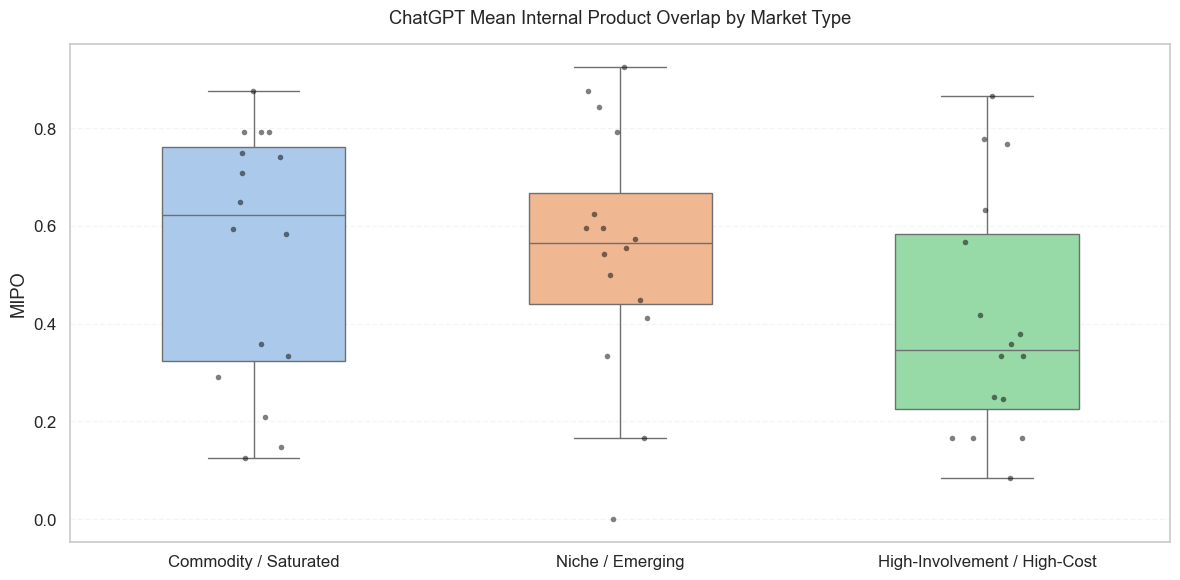

In [5]:
mipo_cs = mipo_df[mipo_df["market_type"] == "Commodity / Saturated"]
mipo_ne = mipo_df[mipo_df["market_type"] == "Niche / Emerging"]
mipo_hh = mipo_df[mipo_df["market_type"] == "High-Involvement / High-Cost"]

plot_df = pd.DataFrame({
    "MIPO": pd.concat([
        mipo_cs["mipo_mean"],
        mipo_ne["mipo_mean"],
        mipo_hh["mipo_mean"],
    ], ignore_index = True),
    "Market Type": (
        ["Commodity / Saturated"] * len(mipo_cs)
        + ["Niche / Emerging"] * len(mipo_ne)
        + ["High-Involvement / High-Cost"] * len(mipo_hh)
    )
})

boxplot(
    df = plot_df,
    x_col = "Market Type",
    y_col = "MIPO",
    order = ["Commodity / Saturated", "Niche / Emerging", "High-Involvement / High-Cost"],
    title = "ChatGPT Mean Internal Product Overlap by Market Type",
    xlabel = "",
    ylabel = "MIPO"
)

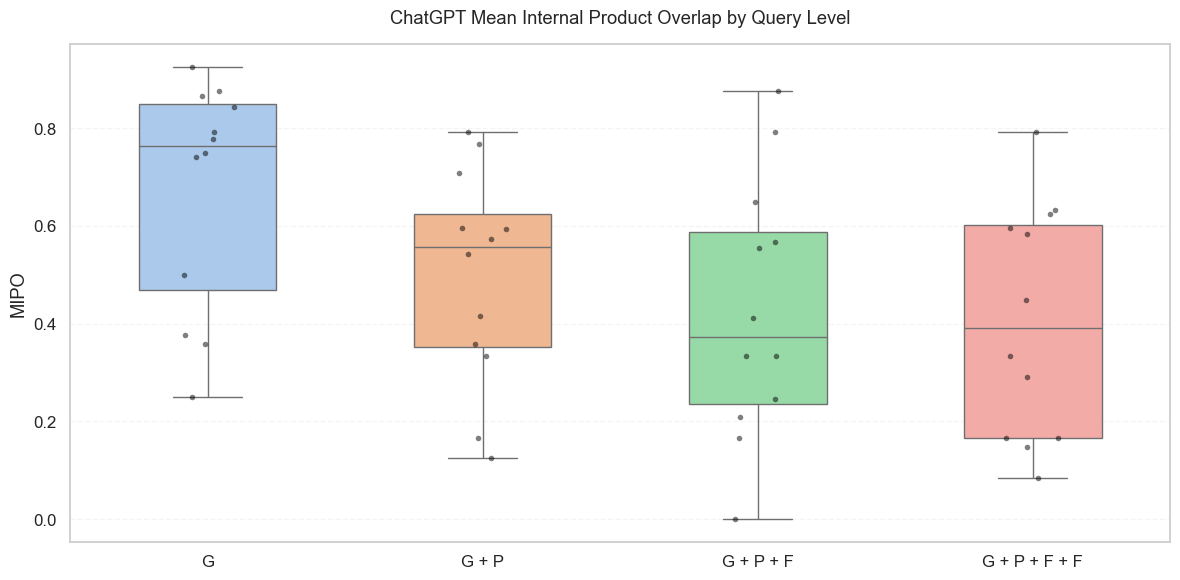

In [6]:
mipo_g = mipo_df[mipo_df["query_level"] == "General"]
mipo_gp = mipo_df[mipo_df["query_level"] == "General & Price"]
mipo_gpf = mipo_df[mipo_df["query_level"] == "General & Price & Feature"]
mipo_gpff = mipo_df[mipo_df["query_level"] == "General & Price & Feature & Feature"]

plot_df = pd.DataFrame({
    "MIPO": pd.concat([
        mipo_g["mipo_mean"],
        mipo_gp["mipo_mean"],
        mipo_gpf["mipo_mean"],
        mipo_gpff["mipo_mean"]
    ], ignore_index = True),
    "Query Level": (
        ["G"] * len(mipo_g)
        + ["G + P"] * len(mipo_gp)
        + ["G + P + F"] * len(mipo_gpf)
        + ["G + P + F + F"] * len(mipo_gpff)
    )
})

boxplot(
    df = plot_df,
    x_col = "Query Level",
    y_col = "MIPO",
    order = ["G", "G + P", "G + P + F", "G + P + F + F"],
    title = "ChatGPT Mean Internal Product Overlap by Query Level",
    xlabel = "",
    ylabel = "MIPO"
)

<h4>Cross-Query Mean Internal Product Overlap – Definition & Implementation</h4>
<p>To go beyond consistency within a single query, we extend the analysis across queries by defining the Cross-Query Mean Internal Product Overlap (CQMIPO). This metric allows us to measure how semantically similar ChatGPT’s product recommendations are between different queries, capturing patterns of overlap in the model’s behavior across topics.</p>

<p> 
Formally, for each query $ q $, let the set of product lists generated by ChatGPT be $ P_{GPT_q} = [p_{q1}, p_{q2}, p_{q3}] $. To measure overlap between two distinct queries $ i $ and $ j $, we define: 
</p> 

<p> 
    $$ CQMIPO[i, j] = \frac{1}{|P_{GPT_i}|\,|P_{GPT_j}|} \sum_{u=1}^{|P_{GPT_i}|} \sum_{v=1}^{|P_{GPT_j}|} O_{\text{semantic}}(p_{iu}, p_{jv}) $$ 
</p> 

<p> 
where $ O_{\text{semantic}}(p_{iu}, p_{jv}) $ denotes the semantic overlap between individual product lists $ p_{iu} $ and \( p_{jv} $. A higher CQMIPO value indicates greater semantic consistency in the model’s product recommendations <em>across queries</em>. 
</p>

In [7]:
def calc_cqmipo(chatgpt_df, filter_col = None):
    
    n = len(chatgpt_df)
    cqmipo_matrix = np.full((n, n), 0, dtype = float)
    product_lists = chatgpt_df["recommended_products"].tolist()
    
    # filter
    filter_values = chatgpt_df[filter_col].tolist() if filter_col else [None] * n
    
    for i in tqdm(range(n), desc = f"Computing CQMIPO (filtered by {filter_col})", unit = "query"):
        for j in range(i, n):
            if filter_col and filter_values[i] != filter_values[j]:
                continue
            
            pairwise_overlaps = [
                semantic_overlap(a, b)
                for a in product_lists[i]
                for b in product_lists[j]
            ]
            cqmipo = np.mean(pairwise_overlaps) if pairwise_overlaps else np.nan
            cqmipo_matrix[i, j] = cqmipo
            cqmipo_matrix[j, i] = cqmipo
    
    return pd.DataFrame(cqmipo_matrix, index = chatgpt_df["query"], columns = chatgpt_df["query"])

Computing CQMIPO (filtered by product):   0%|          | 0/48 [00:00<?, ?query/s]

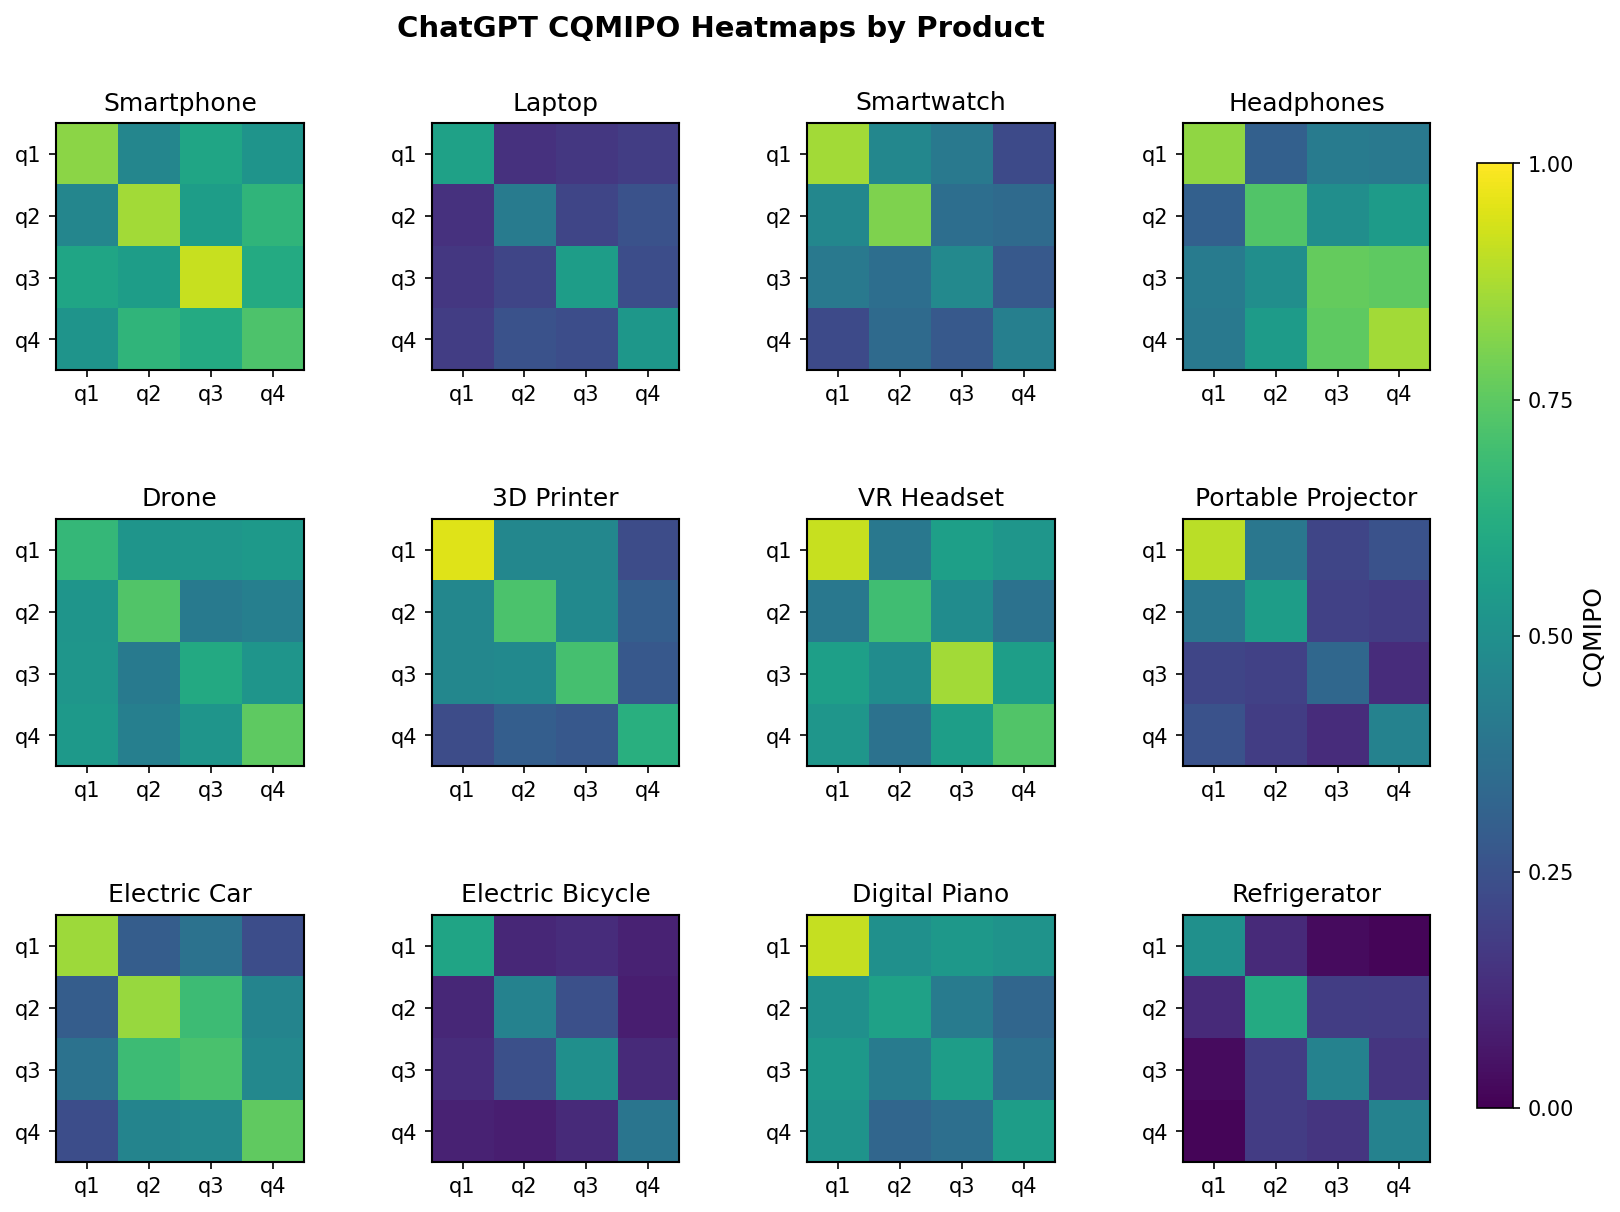

In [8]:
cqmipo_matrix_p = calc_cqmipo(chatgpt_df, filter_col = "product")
heatmaps(cqmipo_matrix_p, chatgpt_df, filter_col = "product", title = "ChatGPT CQMIPO Heatmaps by Product", colorbar_label = "CQMIPO")

Computing CQMIPO (filtered by market_type):   0%|          | 0/48 [00:00<?, ?query/s]

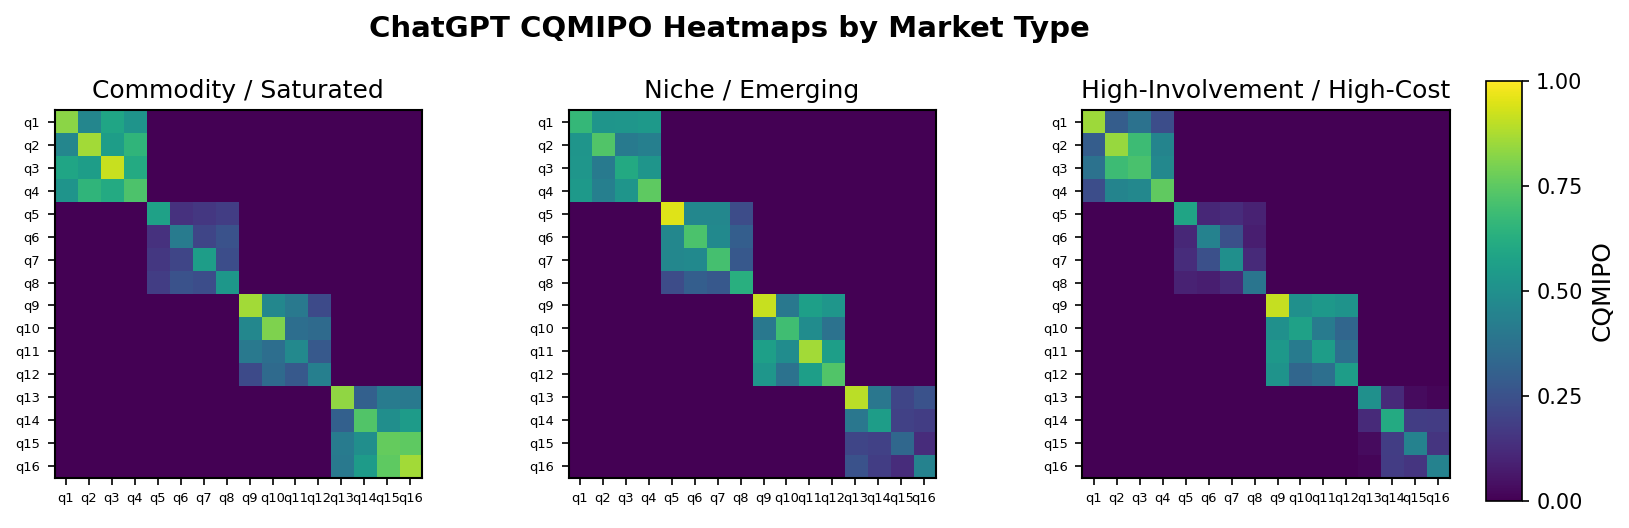

In [9]:
cqmipo_mat_mt = calc_cqmipo(chatgpt_df, filter_col = "market_type")
heatmaps(cqmipo_mat_mt, chatgpt_df, filter_col = "market_type", title = "ChatGPT CQMIPO Heatmaps by Market Type", colorbar_label = "CQMIPO")

In [27]:
def calc_cqopo(chatgpt_df, filter_col = "product", top_n = 10):
    n = len(chatgpt_df)
    cqopo_matrix = np.full((n, n), 0, dtype = float)
    product_lists = chatgpt_df["recommended_products"].tolist()
    
    # filter
    filter_values = chatgpt_df[filter_col].tolist() if filter_col else [None] * n
    
    for i in tqdm(range(n), desc = f"Computing CQMIPO (filtered by {filter_col})", unit = "query"):
        for j in range(i, n):
            if filter_col and filter_values[i] != filter_values[j]:
                continue

            list_i = top_n_semantic_products(product_lists[i], top_n = top_n)
            list_j = top_n_semantic_products(product_lists[j], top_n = top_n)
            
            cqmipo = semantic_overlap(list_i, list_j)
            cqopo_matrix[i, j] = cqmipo
            cqopo_matrix[j, i] = cqmipo
    
    return pd.DataFrame(cqopo_matrix, index = chatgpt_df["query"], columns = chatgpt_df["query"])

Computing CQMIPO (filtered by product):   0%|          | 0/48 [00:00<?, ?query/s]

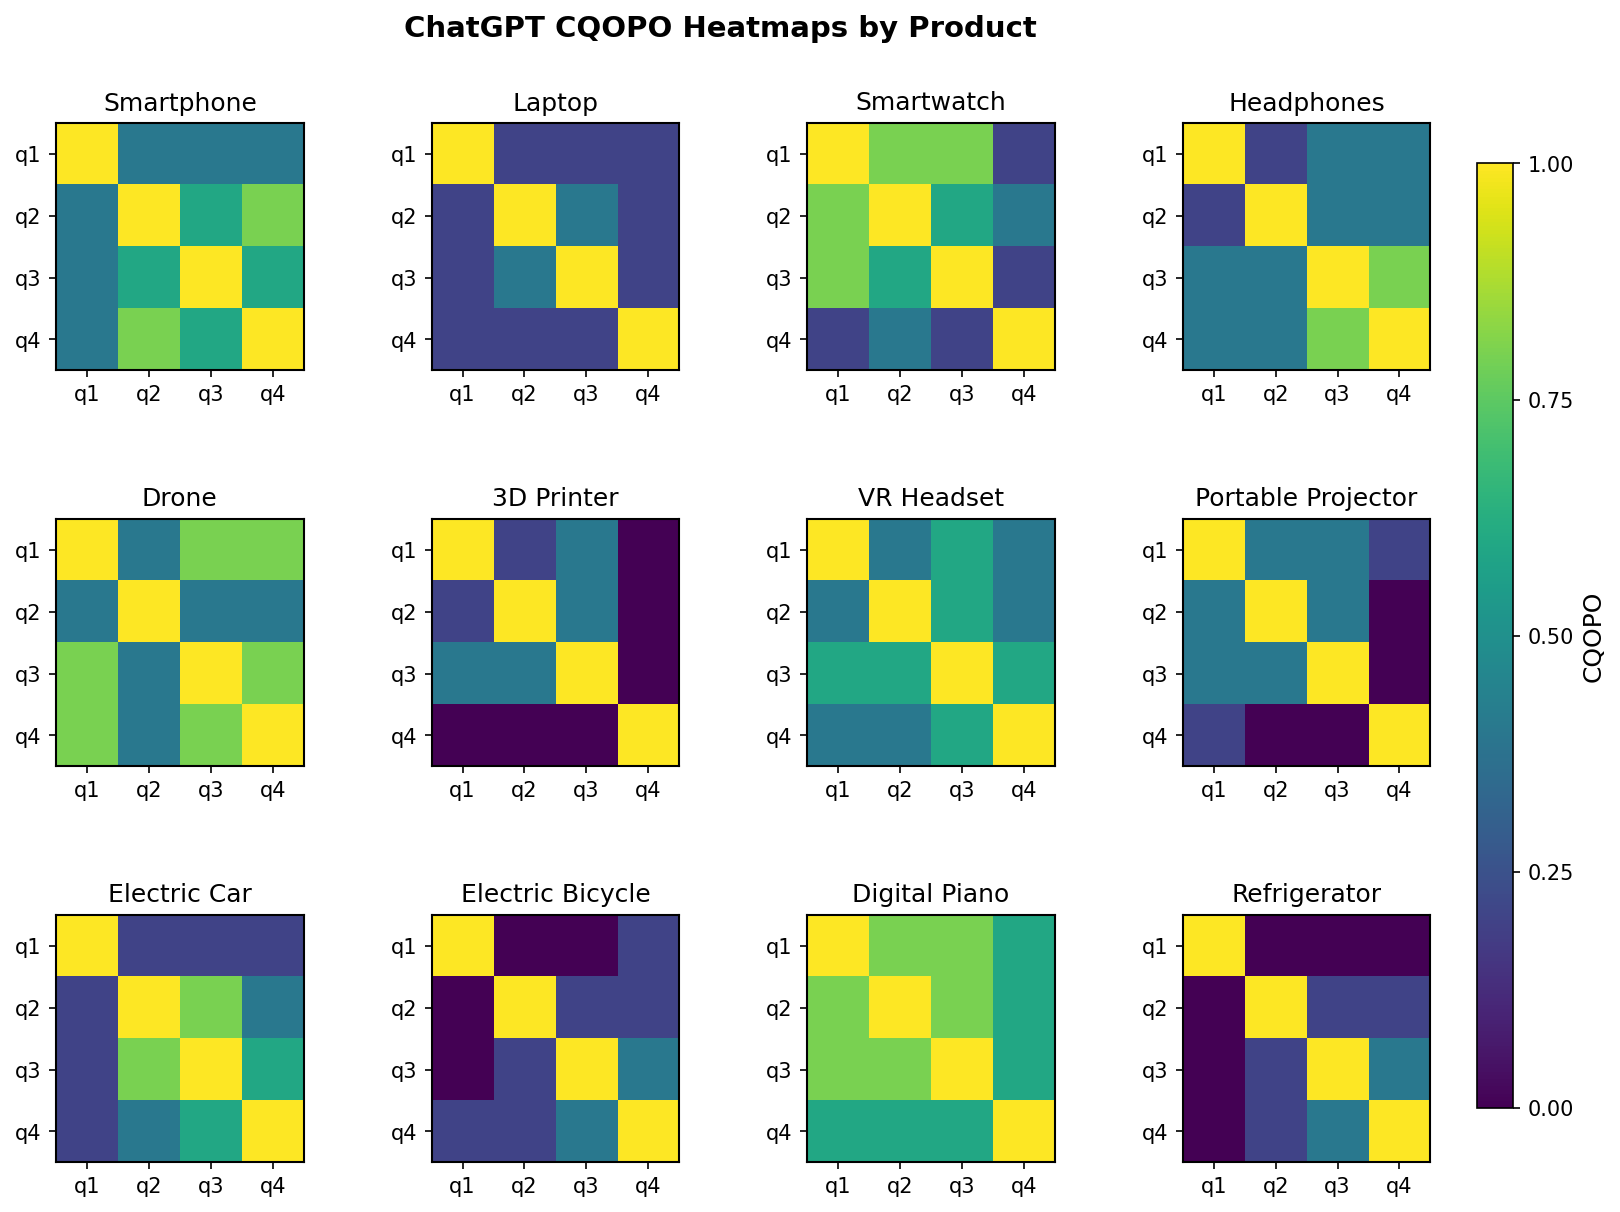

In [28]:
cqopo_mat_p = calc_cqopo(chatgpt_df, filter_col = "product", top_n = 5)
heatmaps(cqopo_mat_p, chatgpt_df, filter_col = "product", title = "ChatGPT CQOPO Heatmaps by Product", colorbar_label = "CQOPO")